<a href="https://colab.research.google.com/github/adefirmanf/health_survey/blob/release/Health_Mental_Survey_Corresponding_Mental_Health_Consequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Initialization packages
import numpy as np
import pandas as pd 
import seaborn as sb
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plot
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# NaiveBayes
from sklearn.naive_bayes import GaussianNB
# Kneighbors
from sklearn.neighbors import KNeighborsClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Custom class for LabelEncoder
class EncoderMultiColumn:
  def __init__ (self, columns):
    self.columns = columns
  
  def DataFrameEncode(self, df):
    if not isinstance(df, pd.DataFrame):
      raise TypeError("type is not pandas.core.frame.DataFrame")
    
    encoder = LabelEncoder()
    for x in self.columns:
      df[x] = encoder.fit_transform(df[x])
    return df

In [ ]:
# Fetching data
data = pd.read_csv('https://query.data.world/s/jpnbsjojct3wr2q4d7t5x4cwlccokm')

# Converting to DataFrame
data_df = pd.DataFrame(data)

# Print head
print(data_df)

                Timestamp  Age  ... obs_consequence comments
0     2014-08-27 11:29:31   37  ...              No      NaN
1     2014-08-27 11:29:37   44  ...              No      NaN
2     2014-08-27 11:29:44   32  ...              No      NaN
3     2014-08-27 11:29:46   31  ...             Yes      NaN
4     2014-08-27 11:30:22   31  ...              No      NaN
...                   ...  ...  ...             ...      ...
1254  2015-09-12 11:17:21   26  ...              No      NaN
1255  2015-09-26 01:07:35   32  ...              No      NaN
1256  2015-11-07 12:36:58   34  ...              No      NaN
1257  2015-11-30 21:25:06   46  ...              No      NaN
1258  2016-02-01 23:04:31   25  ...              No      NaN

[1259 rows x 27 columns]


In [ ]:
# Preprocessing 
# Remove NA values
data_df = data_df.dropna()
print(data_df)
# Remove unecessary values to evaluate
#
# print(data_df.keys())
# Output : 
# Index(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
#        'family_history', 'treatment', 'work_interfere', 'no_employees',
#        'remote_work', 'tech_company', 'benefits', 'care_options',
#        'wellness_program', 'seek_help', 'anonymity', 'leave',
#        'mental_health_consequence', 'phys_health_consequence', 'coworkers',
#        'supervisor', 'mental_health_interview', 'phys_health_interview',
#        'mental_vs_physical', 'obs_consequence', 'comments'],
#       dtype='object')

# Remove Timestamp & comments
clean_data = data_df.drop(['Timestamp', 'comments'], axis=1)

# Gender data seems has many variations values, we should handling these string
# i.e (M, Male, F, Female, m, f) :(
male_index = clean_data[(clean_data['Gender'] == 'Male') | (clean_data['Gender'] == 'male') | (clean_data['Gender'] == 'm') | (clean_data['Gender'] == 'M') ].index
female_index = clean_data[(clean_data['Gender'] == 'Female') | (clean_data['Gender'] == 'female') | (clean_data['Gender'] == 'f') | (clean_data['Gender'] == 'F') ].index

clean_data.loc[male_index,'Gender'] = "Male"
clean_data.loc[female_index,'Gender'] = "Female"

# Also, we categorized invalid gender as Unknown 
unknown_index = clean_data[(clean_data['Gender'] != 'Male') & (clean_data['Gender'] != 'Female')].index
clean_data.loc[unknown_index,'Gender'] = "Unknown"


                Timestamp  ...                                           comments
24    2014-08-27 11:36:48  ...                Relatively new job. Ask again later
25    2014-08-27 11:37:08  ...  Sometimes I think  about using drugs for my me...
33    2014-08-27 11:39:36  ...  I selected my current employer based on its po...
45    2014-08-27 11:43:36  ...  Our health plan has covered my psychotherapy a...
49    2014-08-27 11:44:43  ...  I just started a new job last week hence a lot...
...                   ...  ...                                                ...
1186  2014-11-06 11:24:38  ...  I'm self-employed on contract with small start...
1190  2015-01-03 03:38:30  ...  My mental health issues were the direct result...
1219  2015-02-21 09:48:13  ...  I openly discuss my mental health struggles. I...
1221  2015-02-21 10:45:51  ...  Just starting a new job hence the numerous I d...
1249  2015-07-22 18:57:54  ...                                  Bipolar disorder 

[86 rows x 27 c

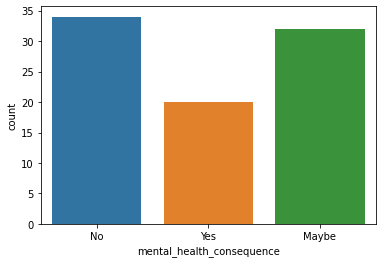

In [ ]:
# Show corresponding data using bar 
sb.countplot(x="mental_health_consequence", data=clean_data)

In [ ]:
# Initialization of datasets
# Reordering the column mental_health_consequence to the last column 
# https://stackoverflow.com/a/50262269
temp_col = clean_data.pop('mental_health_consequence')
clean_data['mental_health_consequence'] = temp_col


print(clean_data)

# We should converting categories data into numerical type (int)
# These data will not encoded to numerical
not_encoded_col = ['Age']
enc_col = clean_data.columns.values.tolist()
col = [x for x in enc_col if x not in not_encoded_col]

# This syntax will mutate the original data
encode = EncoderMultiColumn(col)
encode.DataFrameEncode(clean_data)

values = clean_data.values
X = values[:,0:(len(clean_data.columns)-1)]
Y = values[:,(len(clean_data.columns)-1)]

      Age  Gender  ...  obs_consequence  mental_health_consequence
24     33       1  ...                0                          1
25     35       1  ...                0                          2
33     42       1  ...                0                          0
45     38       0  ...                0                          1
49     30       1  ...                0                          0
...   ...     ...  ...              ...                        ...
1186   56       0  ...                0                          0
1190   44       1  ...                0                          0
1219   38       1  ...                0                          1
1221   46       1  ...                0                          1
1249   30       1  ...                0                          1

[86 rows x 25 columns]


In [ ]:
# Data trainsets
validation_size = 0.20
seed = 2
scoring = 'accuracy'
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [ ]:
# Kfold
kfold = model_selection.KFold(n_splits=4, random_state=seed, shuffle=True)

In [ ]:
names = []
results = []

In [ ]:
# Initiate KNN Classifier
# n_neighbors=10, weights='uniform', algorithm='auto', metric='euclidean'
knn = KNeighborsClassifier()

# Selection model with KNN Classifier
knn_results = model_selection.cross_val_score(knn, X_train, Y_train, cv=kfold, scoring=scoring)
results.append(knn_results)
names.append('KNN')

print(knn_results.mean(), knn_results.std())

0.3235294117647059 0.09754778795162938


In [ ]:
# Initiate NaiveBayes
naive = GaussianNB()

# Selection model with NaiveBayes Classifier
naive_results = model_selection.cross_val_score(naive, X_train, Y_train, cv=kfold, scoring=scoring)
results.append(naive_results)
names.append('NVB')

print(naive_results.mean(), naive_results.std())

0.47058823529411764 0.0831890330807703


In [ ]:
# Random Forest
random_forest = RandomForestClassifier()

# Selection model with RandomForestClassifier
random_forest_results = model_selection.cross_val_score(random_forest, X_train, Y_train, cv=kfold, scoring=scoring)
results.append(random_forest_results)
names.append('RF')

print(random_forest_results.mean(), random_forest_results.std())

0.4852941176470589 0.10502100630210075


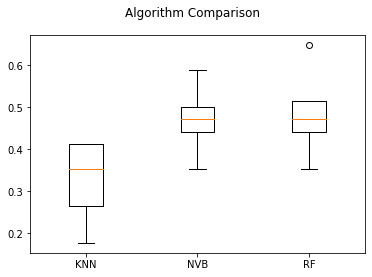

In [ ]:
fig = plot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plot.boxplot(results)
ax.set_xticklabels(names)
plot.show()

In [ ]:
naive.fit(X_train, Y_train)
predictions = naive.predict(X_validation)
# print(confusion_matrix(Y_validation, predictions))
 
print(classification_report(Y_validation, predictions))
print("Score : ",  accuracy_score(Y_validation, predictions))
 

              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.71      1.00      0.83        10
           2       0.67      0.67      0.67         3

    accuracy                           0.72        18
   macro avg       0.79      0.62      0.61        18
weighted avg       0.79      0.72      0.67        18

Score :  0.7222222222222222


In [ ]:
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
print(classification_report(Y_validation, predictions))
print("Score : ",  accuracy_score(Y_validation, predictions))

              precision    recall  f1-score   support

           0       0.33      0.80      0.47         5
           1       0.83      0.50      0.62        10
           2       0.00      0.00      0.00         3

    accuracy                           0.50        18
   macro avg       0.39      0.43      0.37        18
weighted avg       0.56      0.50      0.48        18

Score :  0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
random_forest.fit(X_train, Y_train)
predictions = random_forest.predict(X_validation)
print(classification_report(Y_validation, predictions))
print("Score : ",  accuracy_score(Y_validation, predictions))

              precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.88      0.70      0.78        10
           2       0.67      0.67      0.67         3

    accuracy                           0.67        18
   macro avg       0.66      0.66      0.65        18
weighted avg       0.72      0.67      0.68        18

Score :  0.6666666666666666
